In [61]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full reproducibility (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [62]:
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)



['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [63]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)


predicted class : [ 1 11  9 ... 11  9  1]
predicted probabilities : [0.544058   0.97347754 0.7518662  ... 0.96628433 0.9899086  0.9475812 ]
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : [0.4308202  0.97347754 0.23816009 ... 0.96628433 0.98990858 0.94758117]
true class labels : [ 8 11 11 ... 11  9  1]


In [69]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin * np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


In [64]:
#Indicator funtion and Target TCP Values

indicator = (y_true_class != y_hat).astype(float)
alpha = 0.3
numerator = p_y_star
denominator = p_y_hat + (indicator * (p_y_star + alpha))
tcp_star_targets = numerator / denominator
print("tcp_star_targets shape:", tcp_star_targets)

tcp_star_targets shape: [0.33793047 1.         0.18461646 ... 1.         1.         1.        ]


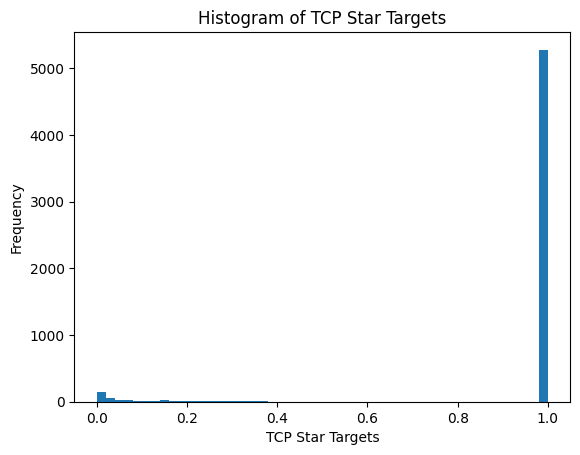

In [65]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [66]:
# Upsampling the errors to create a balanced batch 

# Select indices
correct_idx = np.where(y_hat == y_true_class)[0]
error_idx = np.where(y_hat != y_true_class)[0]

# You can duplicate errors to balance them
n_errors = len(error_idx)
n_correct = len(correct_idx)
upsample_errors = np.random.choice(error_idx, size=n_correct, replace=True)

balanced_idx = np.concatenate([correct_idx, upsample_errors])
np.random.shuffle(balanced_idx)

X_balanced = embeddings[balanced_idx]
y_balanced = tcp_star_targets[balanced_idx]
print("Balanced embeddings shape:", X_balanced.shape)
print("Balanced TCP Star Targets shape:", y_balanced.shape)

Balanced embeddings shape: (10552, 64)
Balanced TCP Star Targets shape: (10552,)


In [67]:
tcp_targets= p_y_star / p_y_hat
print(tcp_targets.shape)

(5702,)


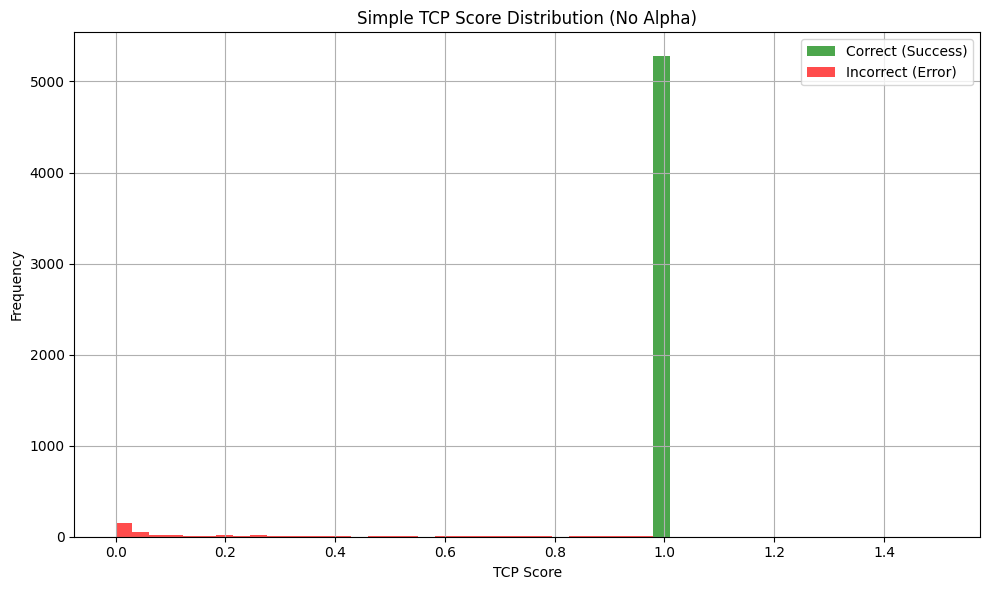

In [68]:
# --- Plot histogram of TCP scores ---
is_correct = (y_hat == y_true_class)

success_tcp = tcp_targets[is_correct]
error_tcp = tcp_targets[~is_correct]

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1.5, 50)
plt.hist(success_tcp, bins=bins, alpha=0.7, label='Correct (Success)', color='green')
plt.hist(error_tcp, bins=bins, alpha=0.7, label='Incorrect (Error)', color='red')
plt.xlabel("TCP Score")
plt.ylabel("Frequency")
plt.title("Simple TCP Score Distribution (No Alpha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
ece_tcp = compute_ECE(tcp_targets, y_hat, y_labels_int)
print(f"ECE for Simple TCP: {ece_tcp:.4f}")

ECE for Simple TCP: 0.0175


In [49]:
X= X_balanced
y= y_balanced

In [50]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [51]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [52]:
print(y_hat)
print(y_true_class)


[ 1 11  9 ... 11  9  1]
[ 8 11 11 ... 11  9  1]


In [53]:
# Adding LDS

from scipy.ndimage import gaussian_filter1d
n_bins=100
bin_edges = np.linspace(0, 1, n_bins + 1)
bin_ids = np.digitize(tcp_star_targets, bins=bin_edges) - 1
bin_ids = np.clip(bin_ids, 0, n_bins - 1)

#computing a smoothed label density
bin_counts = np.bincount(bin_ids, minlength=n_bins).astype(np.float32)
smoothed_density = gaussian_filter1d(bin_counts, sigma=2)

#inverse weights from the smoothed density
weights = 1.0 / (smoothed_density[bin_ids] + 1e-6)
weights = weights / np.mean(weights) 

In [54]:
#Using these weights in training
import torch
from torch.utils.data import WeightedRandomSampler, TensorDataset, DataLoader

sample_weights = torch.tensor(weights, dtype=torch.float32)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


train_dataset= TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader= DataLoader(val_dataset, batch_size=64)


In [55]:
# Adding FDS

def compute_fds_means(features, bin_ids, n_bins=100, sigma=2):
    feature_dim = features.size(1)
    means = torch.zeros(n_bins, feature_dim)
    counts = torch.zeros(n_bins)

    for b in range(n_bins):
        in_bin = (bin_ids == b)
        if torch.any(in_bin):
            means[b] = features[in_bin].mean(dim=0)
            counts[b] = in_bin.sum()

    # Gaussian smoothing
    smoothed = gaussian_filter1d(means.numpy(), sigma=sigma, axis=0)
    return torch.tensor(smoothed, dtype=torch.float32)

In [56]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
input_dim = X_train.shape[1]
model = ConfidenceNet(input_dim)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

fds_enabled = True
fds_means = None  # to be updated each epoch

for epoch in range(50):
    model.train()
    train_losses = []
    
    all_features = []
    all_targets = []
    
    for xb, yb in train_loader:
        if fds_enabled and fds_means is not None:
            with torch.no_grad():
                bins = torch.tensor(np.digitize(yb.numpy(), bins=bin_edges) - 1)
                bins = torch.clamp(bins, 0, n_bins - 1)
                xb = xb - xb + fds_means[bins]  # replace with smoothed bin mean

        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        all_features.append(xb.detach())
        all_targets.append(yb.detach())

    # Update FDS bin means after each epoch
    if fds_enabled:
        all_features = torch.cat(all_features, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        bin_ids_full = torch.tensor(np.digitize(all_targets.numpy(), bins=bin_edges) - 1)
        bin_ids_full = torch.clamp(bin_ids_full, 0, n_bins - 1)
        fds_means = compute_fds_means(all_features, bin_ids_full)

    # Validation (no FDS applied here)
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

Epoch 01 | Train Loss: 0.444469 | Val Loss: 0.563508
Epoch 02 | Train Loss: 0.121980 | Val Loss: 8.866887
Epoch 03 | Train Loss: 0.119547 | Val Loss: 11.157580
Epoch 04 | Train Loss: 0.141865 | Val Loss: 6.777496
Epoch 05 | Train Loss: 0.126297 | Val Loss: 2.754033
Epoch 06 | Train Loss: 0.122953 | Val Loss: 3.053439
Epoch 07 | Train Loss: 0.126437 | Val Loss: 1.739122
Epoch 08 | Train Loss: 0.120107 | Val Loss: 2.253724
Epoch 09 | Train Loss: 0.124336 | Val Loss: 3.006172
Epoch 10 | Train Loss: 0.121799 | Val Loss: 2.829184
Epoch 11 | Train Loss: 0.122590 | Val Loss: 4.716347
Epoch 12 | Train Loss: 0.119503 | Val Loss: 7.176943
Epoch 13 | Train Loss: 0.121721 | Val Loss: 6.868394
Epoch 14 | Train Loss: 0.140634 | Val Loss: 14.239002
Epoch 15 | Train Loss: 0.127627 | Val Loss: 2.839298
Epoch 16 | Train Loss: 0.118963 | Val Loss: 3.174052
Epoch 17 | Train Loss: 0.120255 | Val Loss: 3.063360
Epoch 18 | Train Loss: 0.119453 | Val Loss: 2.695671
Epoch 19 | Train Loss: 0.121506 | Val Loss: 

In [57]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores = model(X_test_tensor).numpy()  # shape: (5702,)
print("Confidence scores shape:", confidence_scores.shape) #score from the final sigmoid layer

Confidence scores shape: (5702,)


In [58]:
#min and max values of confidence scores
print("Min value in confidence scores:", np.min(confidence_scores))
print("Max value in confidence scores:", np.max(confidence_scores))

Min value in confidence scores: 3.5429265e-16
Max value in confidence scores: 1.0


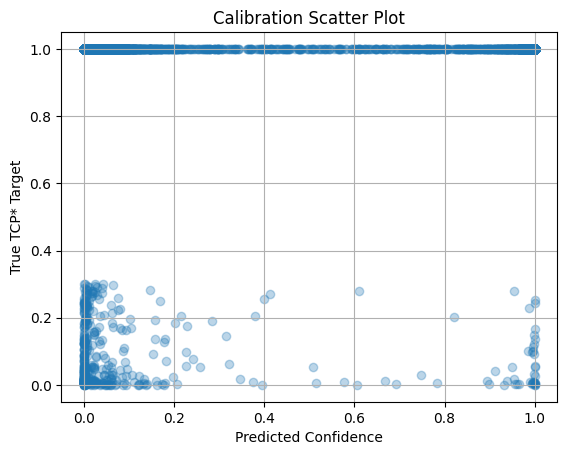

In [59]:
plt.scatter(confidence_scores, tcp_star_targets, alpha=0.3)
plt.xlabel("Predicted Confidence")
plt.ylabel("True TCP* Target")
plt.title("Calibration Scatter Plot")
plt.grid(True)


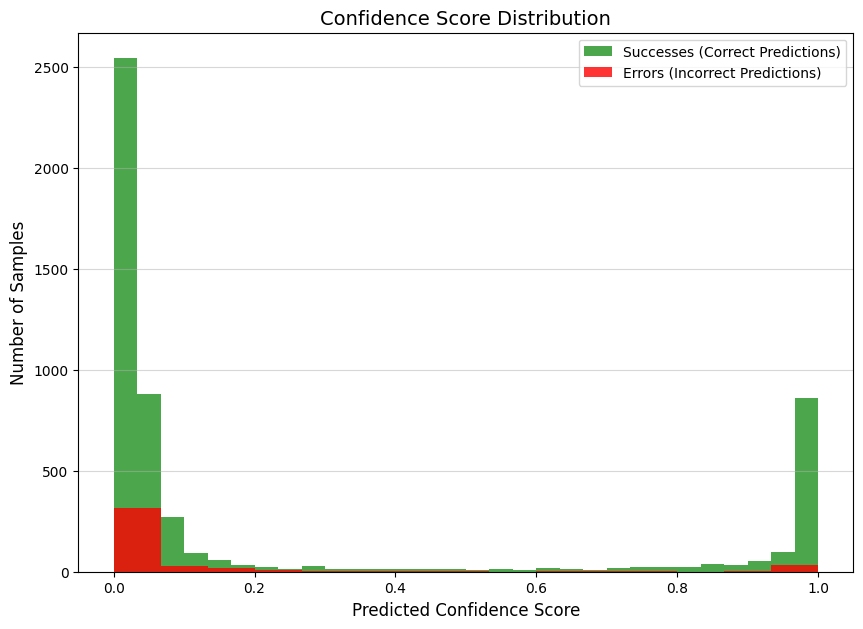

In [60]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores[is_correct]
error_confidences = confidence_scores[~is_correct]

plt.figure(figsize=(10, 7))
# bins = np.linspace(0, 1, 50)
# plt.hist(success_confidences, bins=bins, alpha=0.7, label='Success', color='green')
# plt.hist(error_confidences, bins=bins, alpha=0.7, label='Error', color='red')

plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

